# Chapter 4.4: Tounge Shapes

### NOTE: RUNNING THIS NOTEBOOK MAY TAKE A LONG TIME (>20 Minutes)

In [2]:
devtools::install("../../elasticproc2d", quiet=TRUE, quick=TRUE)
library(elasticproc2d)

In [3]:
library(dplyr)
library(viridis)
library(RColorBrewer)
library(ggplot2)
library(grid)
library(gridExtra)
library(tidyr)
library(tibble)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [4]:
theme_thesis <- function(){ 
    theme_bw() %+replace%    #replace elements we want to change
    theme()
}

# Display plots in smaller size
options(repr.plot.width=10, repr.plot.height=6)

#### Load Dataset

In [5]:
# From '..phonetik/code/Rfiles/readdata.R'
pouplier <- read.csv(file = "../data/phonetik_consulting/Daten/UltrasoundData_Frame3_AllSpeakers.txt", sep = "\t", header = TRUE)
pouplier$COMPL <- pouplier$RHO * exp(1.i*pouplier$THETA)
pouplier$X1 <- Re(pouplier$COMPL)
pouplier$X2 <- Im(pouplier$COMPL)

In [6]:
head(pouplier)

VPN REP FRAME WORD VCODE CCODE THETA RHO     COMPL              X1      
1 D1  1   3     pada aa    d     1.037 57.0108 29.00739+49.07955i 29.00739
2 D1  1   3     pada aa    d     1.088 56.9207 26.42587+50.41467i 26.42587
3 D1  1   3     pada aa    d     1.138 56.2112 23.57559+51.02833i 23.57559
4 D1  1   3     pada aa    d     1.189 54.8924 20.45225+50.93997i 20.45225
5 D1  1   3     pada aa    d     1.239 53.9110 17.56107+50.97063i 17.56107
6 D1  1   3     pada aa    d     1.290 53.1188 14.72033+51.03841i 14.72033
  X2      
1 49.07955
2 50.41467
3 51.02833
4 50.93997
5 50.97063
6 51.03841

In [7]:
unique(pouplier$WORD)

[1] "pada" "padi" "pala" "pali" "pana" "pani" "pasa" "pasi" "pida" "pidi"
[11] "pila" "pili" "pina" "pini" "pisa" "pisi" "pade" "pale" "pane" "pase"
[21] "peda" "pede" "pela" "pele" "pena" "pene" "pesa" "pese"

In [8]:
unique(pouplier$CCODE)

[1] "d" "l" "n" "s"

In [9]:
unique(pouplier$VCODE)

[1] "aa" "ai" "ia" "ii" "ae" "ea" "ee"

#### Functions for plotting

In [10]:
rot_align_to <- function(mean, mean_to){
    # Nicht ganz sauber, weil kein warping alignment zwischen den Means!!!
    avg.rot_to <- mean(sapply(mean_to$data_curves, function(curve){
        attr(curve, "rotation")
    }))
    coefs1 <- complex(re=mean$coefs[,1], im=mean$coefs[,2])
    coefs2 <- complex(re=mean_to$coefs[,1], im=mean_to$coefs[,2])
    G <- elasticproc2d:::get_gram_matrix(mean$knots, mean$type)
    w <- Conj(coefs1) %*% G %*% coefs2
    rot <- Arg(w)
    avg.rot_to - rot
}

get_aligned_pfits <- function(mean, center=FALSE, rot_global=NULL){
    avg.rot <- mean(sapply(mean$data_curves, function(curve){
        attr(curve, "rotation")
    }))
    if(!is.null(rot_global)){
        avg.rot <- rot_global
    }
    mat.rot <- matrix(c(cos(- avg.rot), - sin(- avg.rot), sin(- avg.rot), cos(- avg.rot)), nrow = 2, ncol = 2)
    pfits <- lapply(mean$data_curves, function(curve){
        pfit <- get_procrustes_fit(curve)
        t <- pfit$t
        t_optim <- pfit$t_optim
        curve <- as.data.frame(as.matrix(pfit[,c(3,4)]) %*% mat.rot)
        if(!center){
            curve[,1] <- curve[,1] - curve[nrow(curve),1]
            curve[,2] <- curve[,2] - curve[nrow(curve),2]
        }
        colnames(curve) <- c("X1", "X2")
        curve <- add_column(curve, t=t, t_optim=t_optim, .before=1)
        curve
    })
    pfits
}
    
get_aligned_mean <- function(mean, center=FALSE, rot_global=NULL){
    avg.rot <- mean(sapply(mean$data_curves, function(curve){
        attr(curve, "rotation")
    }))
    if(!is.null(rot_global)){
        avg.rot <- rot_global
    }
    mat.rot <- matrix(c(cos(- avg.rot), - sin(- avg.rot), sin(- avg.rot), cos(- avg.rot)), nrow = 2, ncol = 2)
    mean.rot <- as.data.frame(as.matrix(get_evals(mean)) %*% mat.rot)
    if(!center){
        mean.rot[,1] <- mean.rot[,1] - mean.rot[nrow(mean.rot),1]
        mean.rot[,2] <- mean.rot[,2] - mean.rot[nrow(mean.rot),2]
    }
    colnames(mean.rot) <- c("X1", "X2")
    mean.rot
}

build_df_from_group <- function(gf.list, gf.keys){
    gf.list <- lapply(seq_along(gf.list), function(i){
        rep <- gf.list[[i]]
        key <- gf.keys[i,]
        key.rep <- lapply(seq(1,nrow(rep)), function(j){key})
        key.rep <- bind_rows(key.rep)
        bind_cols(key.rep, rep)
    })
    bind_rows(gf.list, .id="id")
}

In [11]:
df <- pouplier %>%
    filter(VCODE %in% c("aa", "ii")) %>%
    select(CCODE, VCODE, VPN, REP, X1, X2) %>%
    arrange(CCODE, VCODE, VPN, REP)

In [12]:
v.gf <- df %>%
    select(CCODE, VCODE, VPN, REP, X1, X2) %>%
    group_by(CCODE, VCODE, VPN, REP)

v.list <- group_split(v.gf, .keep=FALSE)
v.key <- group_keys(v.gf)

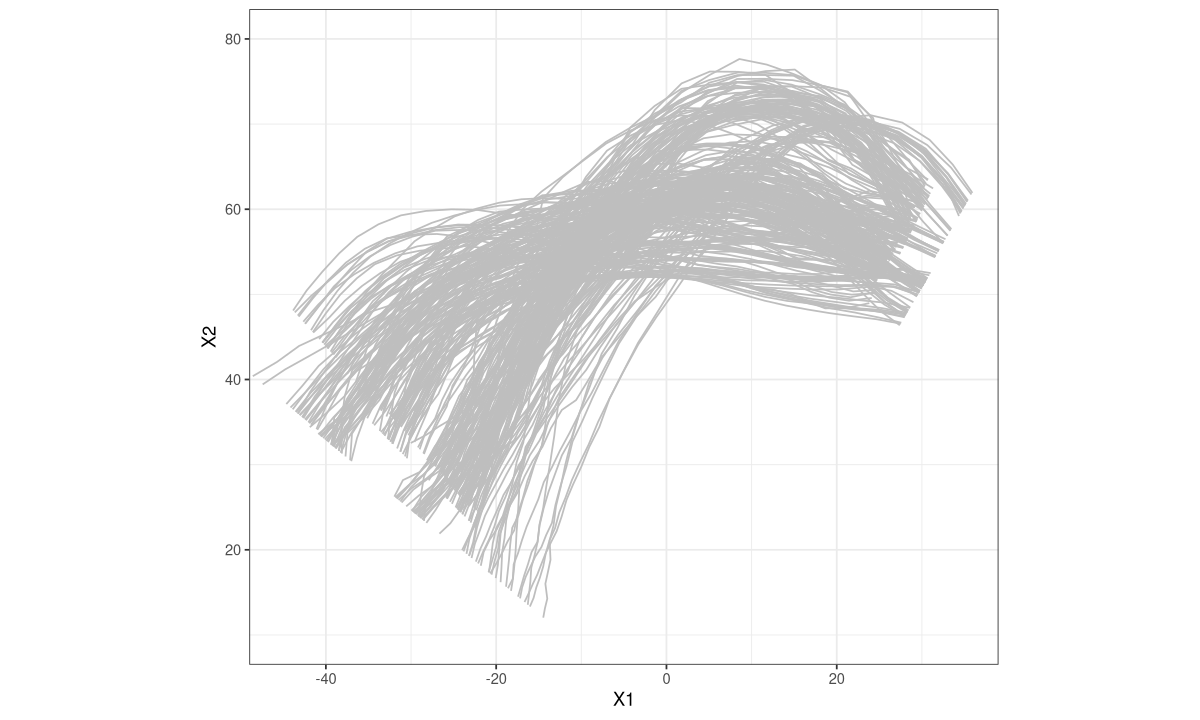

In [13]:
ggplot(bind_rows(v.list, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey") +
    coord_fixed(xlim=c(-45,35), ylim=c(10,80)) +
    theme_thesis()

# Analyzing Variability of Tounge Shapes using Group Means and Distances

In [17]:
vows <- c("aa", "ii", "aa+ii")
cons <- c("d", "l", "n", "s", "d+l+n+s")
vpns <- c("D1", "D3", "D4", "D5", "D6", "D7")

In [18]:
knots <- seq(0, 1, length = 13)

## a) Means over all Speakers

In [19]:
means <- lapply(seq_along(vows), function(i){
    lapply(seq_along(cons), function(j){
        if (vows[i] == "aa+ii" && cons[j] == "d+l+n+s"){
            curves <- v.gf
        } else if (vows[i] == "aa+ii") {
            curves <- v.gf %>% filter(CCODE == cons[j])
        } else if (cons[j] == "d+l+n+s"){
            curves <- v.gf %>% filter(VCODE == vows[i])
        } else {
            curves <- v.gf %>% filter(VCODE == vows[i], CCODE == cons[j])
        }
        curves <- curves %>% group_split(.keep=FALSE)
        mean <- compute_elastic_proc2d_mean(curves, knots = knots, type = "smooth", penalty = 2)
        mean
    })
})

In [20]:
pfits <- bind_rows(lapply(seq_along(vows), function(i){
    bind_rows(lapply(seq_along(cons), function(j){
        pfits <- get_aligned_pfits(means[[i]][[j]])
        pfits <- bind_rows(pfits, .id="REP")
        data.frame(VCODE=vows[i], CCODE=cons[j], pfits)
    }))
}))

In [21]:
mean.evals <- bind_rows(lapply(seq_along(vows), function(i){
    bind_rows(lapply(seq_along(cons), function(j){
        mean <- get_aligned_mean(means[[i]][[j]])
        data.frame(VCODE=vows[i], CCODE=cons[j], mean)
    }))
}))

In [22]:
dists <- bind_rows(lapply(seq_along(vows), function(i){
    bind_rows(lapply(seq_along(cons), function(j){
        dist <- sapply(means[[i]][[j]]$data_curves, function(curve){attr(curve, "dist_to_mean")})
        dist <- data.frame(VCODE=vows[i], CCODE=cons[j], dist)
        dist
    }))
}))

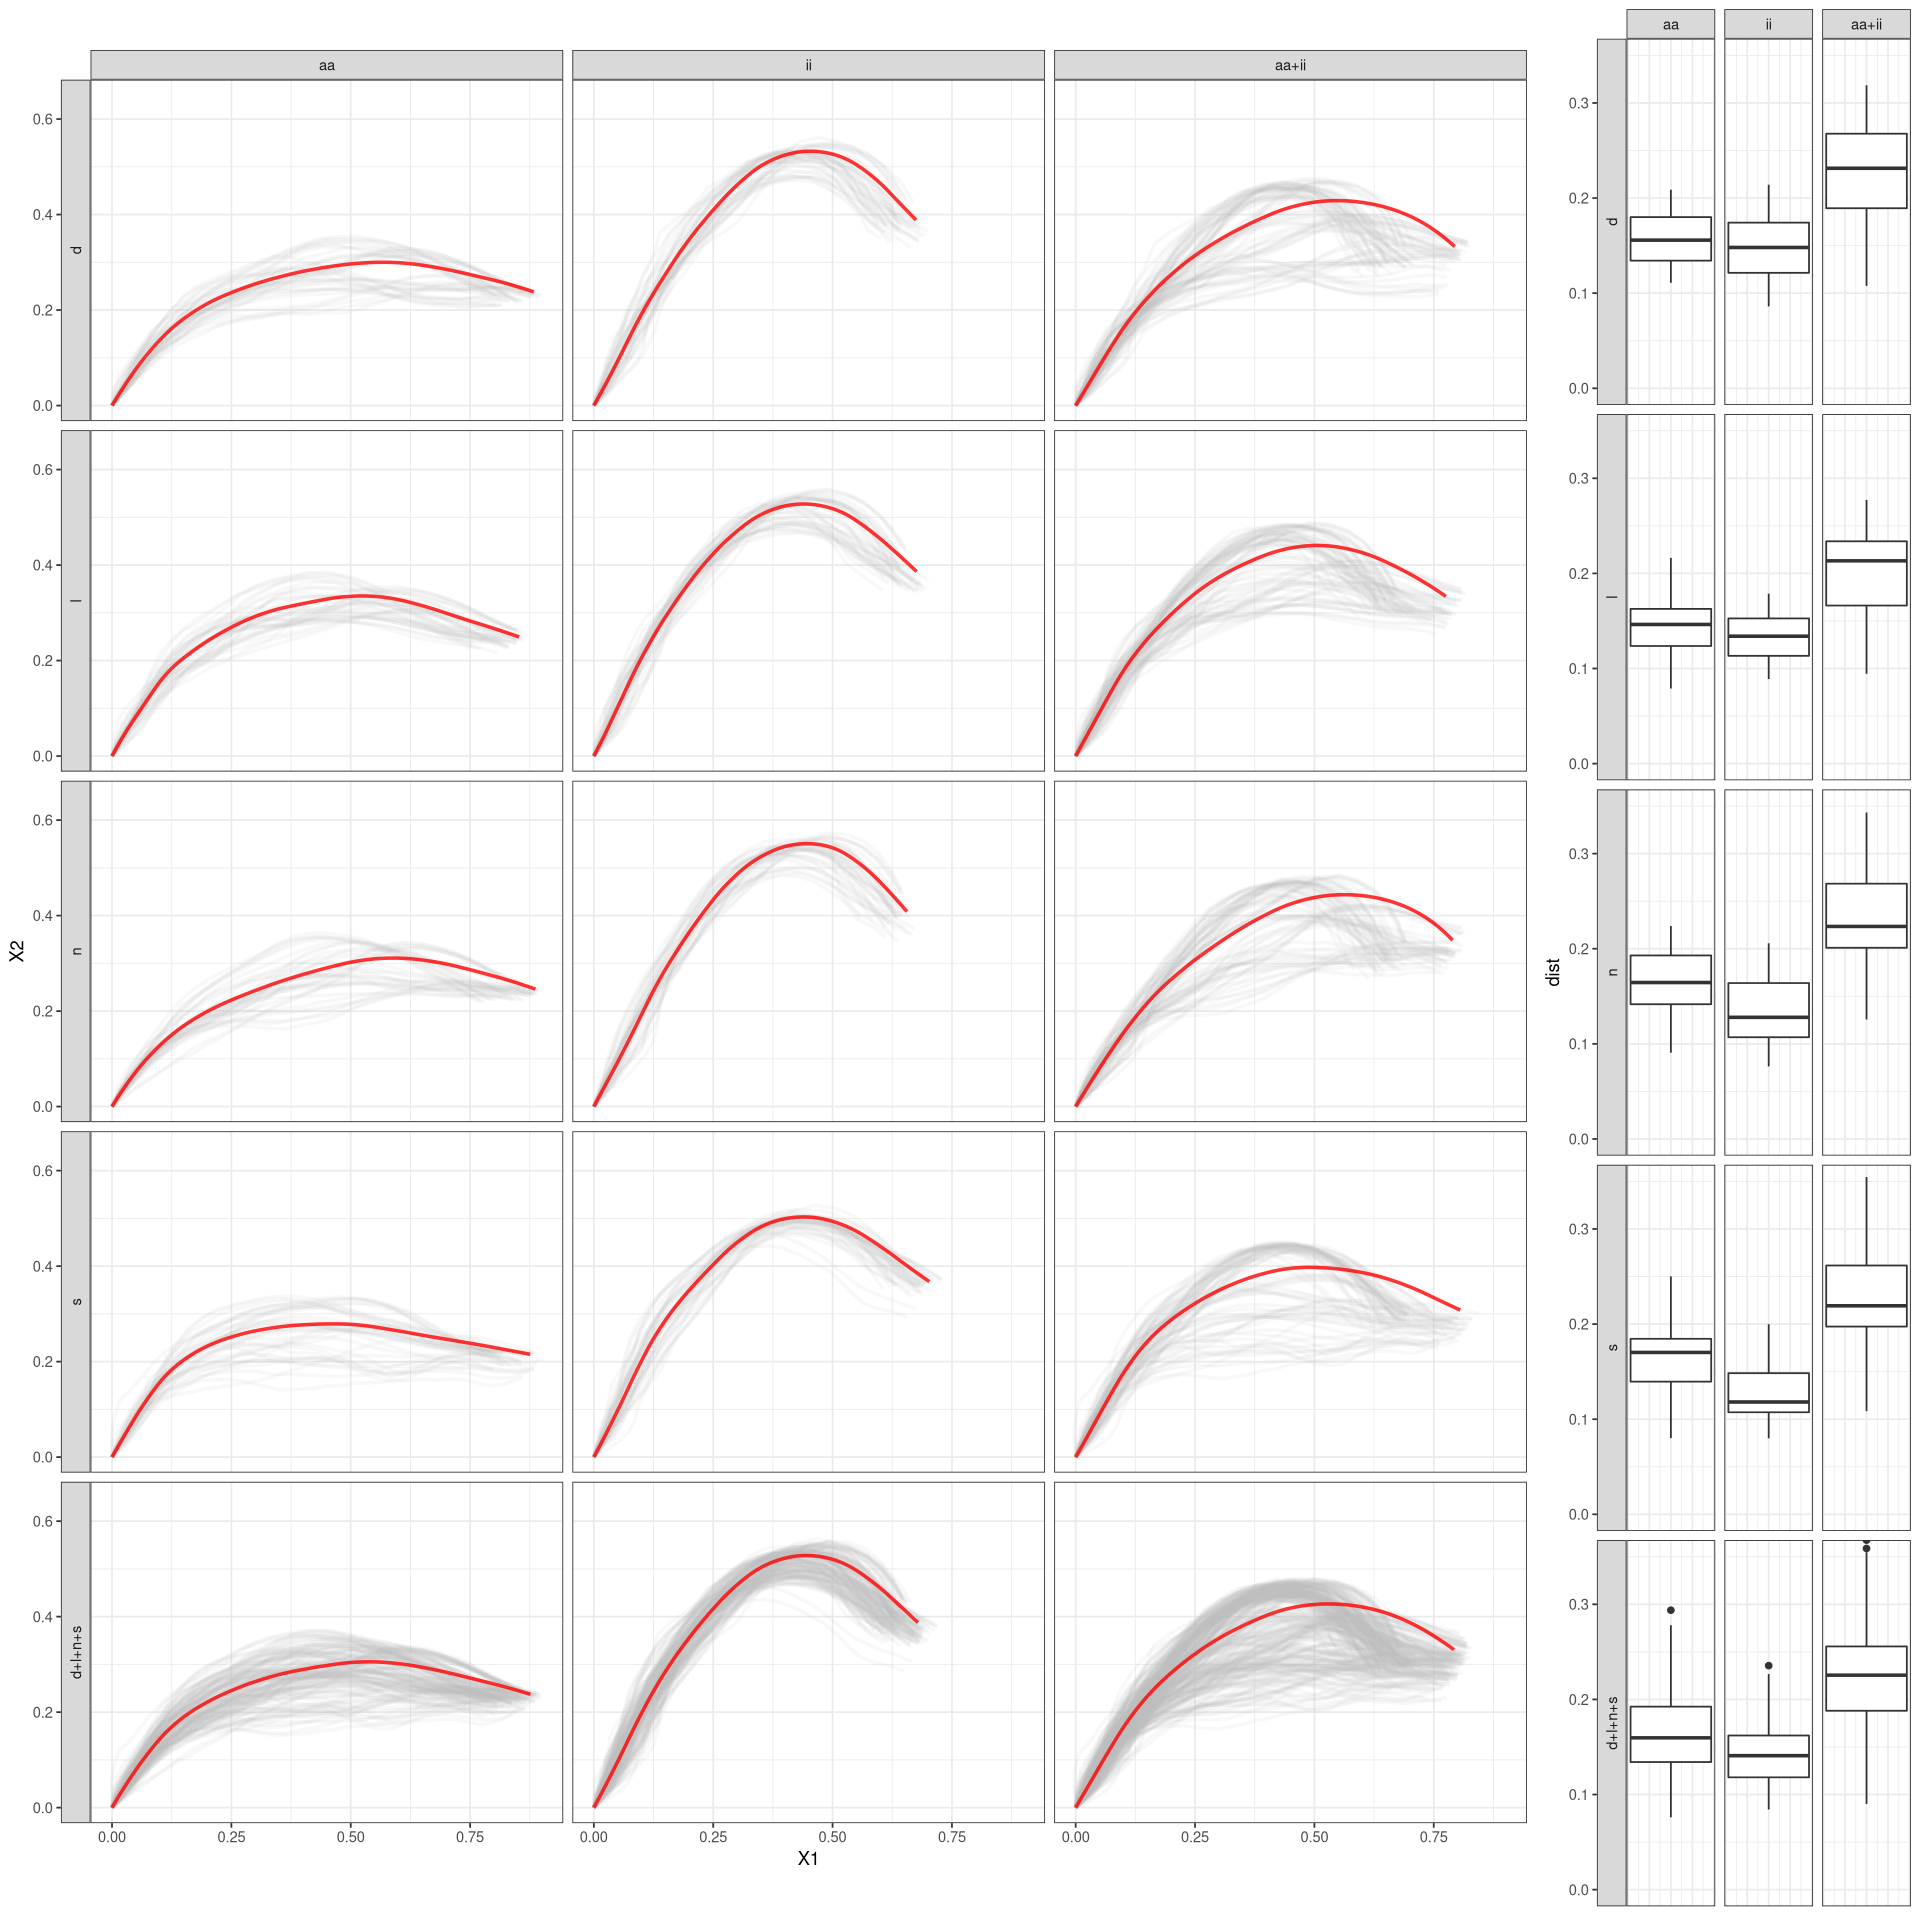

In [23]:
p1 <- ggplot(pfits, aes(x=X1, y=X2)) + 
    geom_path(aes(group=REP), size = 1, show.legend=FALSE, color="grey", alpha=0.1) +
    geom_path(data=mean.evals, size=1, show.legend=FALSE, color="red", alpha=0.8) +
    coord_fixed(xlim=c(0,0.9),ylim=c(0,0.65)) +
    theme_thesis() +
    facet_grid(cols=vars(factor(VCODE, levels = c("aa", "ii", "aa+ii"))), 
               rows=vars(factor(CCODE, levels = c("d", "l", "n", "s", "d+l+n+s"))), 
               switch="y")
    
p2 <- ggplot(dists) +
    geom_boxplot(aes(y=dist),show.legend=FALSE) +
    theme_thesis() +
    coord_cartesian(ylim=c(0,0.35)) +
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) +
    facet_grid(cols=vars(factor(VCODE, levels = c("aa", "ii", "aa+ii"))), 
               rows=vars(factor(CCODE, levels = c("d", "l", "n", "s", "d+l+n+s"))), 
               switch="y")
options(repr.plot.width=16, repr.plot.height=16)
g <- arrangeGrob(p1, p2, widths=c(4,1))
ggsave("total_means.png", g, width=12, height=12, device="png", dpi=200)
grid.draw(g)

## b.) Means per Speaker

In [24]:
vpn.means <- lapply(seq_along(vows), function(i){
    lapply(seq_along(cons), function(j){
        lapply(seq_along(vpns), function(k){
            if (vows[i] == "aa+ii" && cons[j] == "d+l+n+s"){
                curves <- v.gf %>% filter(VPN == vpns[k])
            } else if (vows[i] == "aa+ii") {
                curves <- v.gf %>% filter(CCODE == cons[j], VPN == vpns[k])
            } else if (cons[j] == "d+l+n+s"){
                curves <- v.gf %>% filter(VCODE == vows[i], VPN == vpns[k])
            } else {
                curves <- v.gf %>% filter(VCODE == vows[i], CCODE == cons[j], VPN == vpns[k])
            }
            curves <- curves %>% group_split(.keep=FALSE)
            mean <- compute_elastic_proc2d_mean(curves, knots = knots, type = "smooth", penalty = 2)
            mean
        })
    })
})

In [25]:
vpn.pfits <- bind_rows(lapply(seq_along(vows), function(i){
    bind_rows(lapply(seq_along(cons), function(j){
        bind_rows(lapply(seq_along(vpns), function(k){
            rot.global <- rot_align_to(vpn.means[[i]][[j]][[k]], means[[i]][[j]])
            pfits <- get_aligned_pfits(vpn.means[[i]][[j]][[k]], rot_global=rot.global)
            pfits <- bind_rows(pfits, .id="REP")
            data.frame(VCODE=vows[i], CCODE=cons[j], VPN=vpns[k], pfits)
        }))
    }))
}))

In [26]:
vpn.mean.evals <- bind_rows(lapply(seq_along(vows), function(i){
    bind_rows(lapply(seq_along(cons), function(j){
        bind_rows(lapply(seq_along(vpns), function(k){
            rot.global <- rot_align_to(vpn.means[[i]][[j]][[k]], means[[i]][[j]])
            mean <- get_aligned_mean(vpn.means[[i]][[j]][[k]], rot_global=rot.global)
            data.frame(VCODE=vows[i], CCODE=cons[j], VPN=vpns[k], mean)
        }))
    }))
}))

In [27]:
vpn.dists <- bind_rows(lapply(seq_along(vows), function(i){
    bind_rows(lapply(seq_along(cons), function(j){
        bind_rows(lapply(seq_along(vpns), function(k){
            dist <- sapply(vpn.means[[i]][[j]][[k]]$data_curves, function(curve){attr(curve, "dist_to_mean")})
            dist <- data.frame(VCODE=vows[i], CCODE=cons[j], VPN=vpns[k], dist)
            dist
        }))
    }))
}))

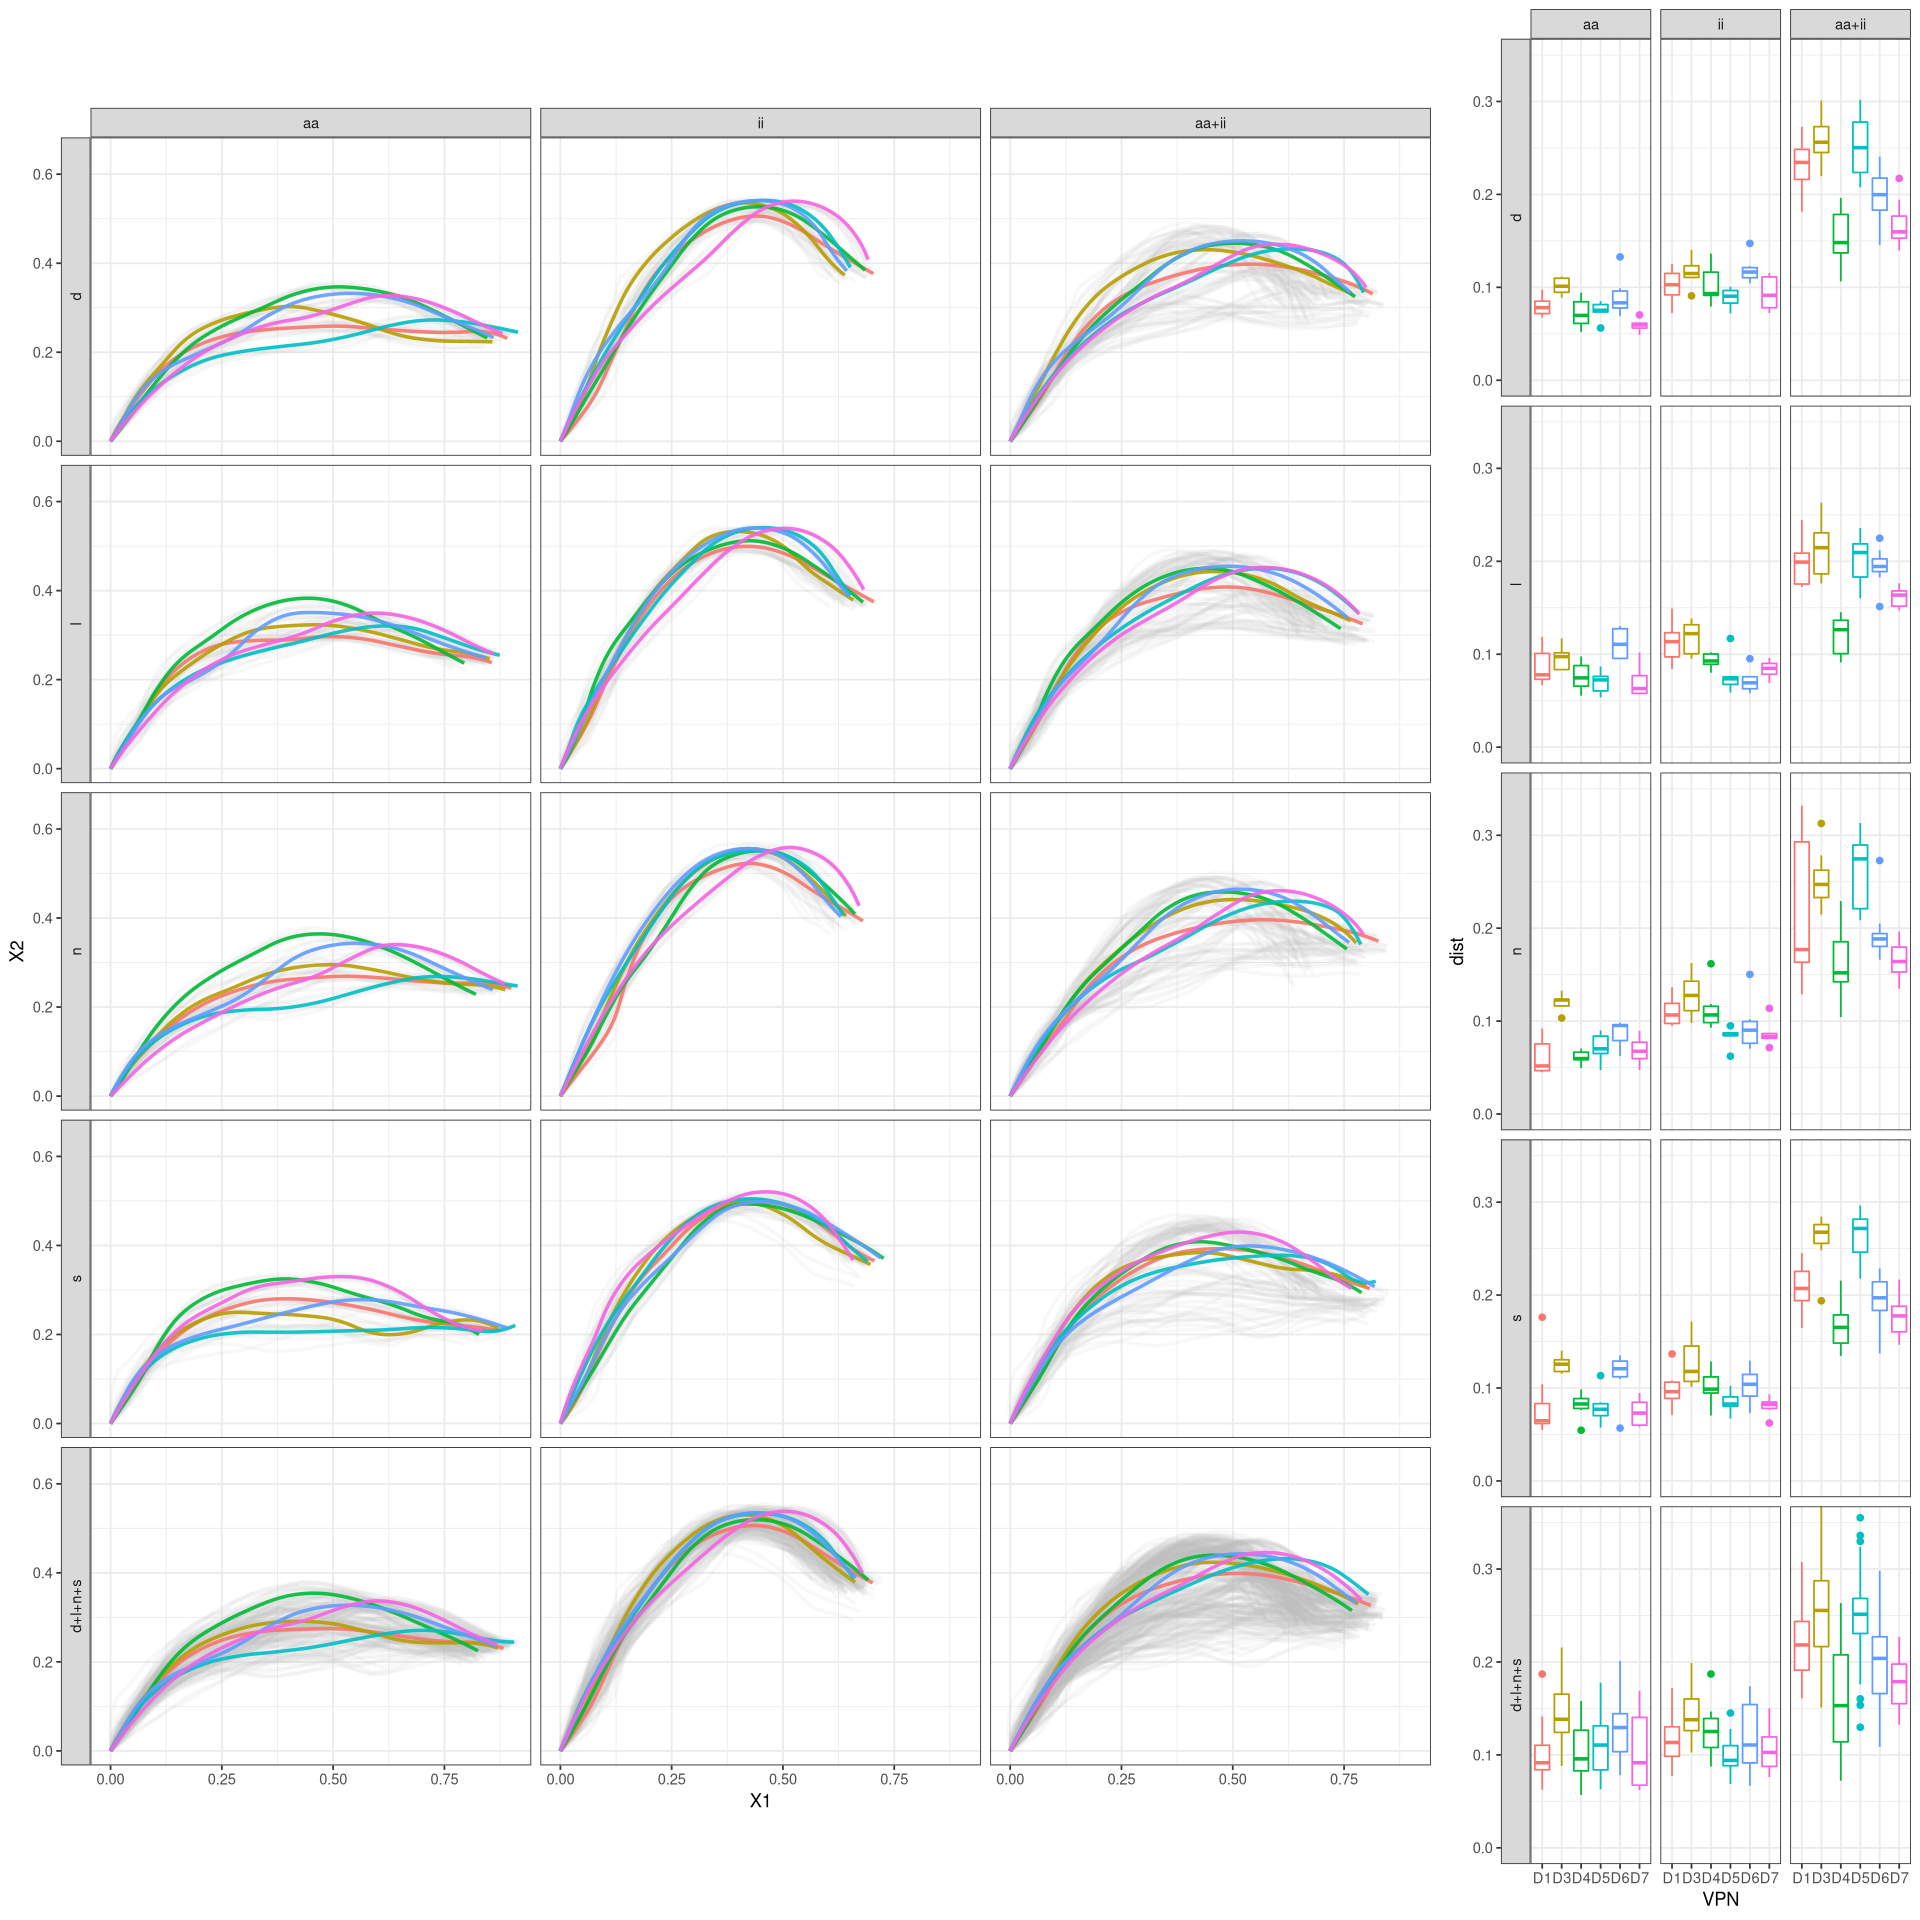

In [28]:
p1 <- ggplot(vpn.pfits, aes(x=X1, y=X2)) + 
    geom_path(aes(group=interaction(VPN, REP)), color="grey", size = 1, show.legend=FALSE, alpha=0.1) +
    geom_path(data=vpn.mean.evals, aes(group=VPN, color=VPN), size=1, show.legend=FALSE,alpha=0.9) +
    coord_fixed(xlim=c(0,0.9),ylim=c(0,0.65)) +
    theme_thesis() +
    facet_grid(cols=vars(factor(VCODE, levels = c("aa", "ii", "aa+ii"))), 
               rows=vars(factor(CCODE, levels = c("d", "l", "n", "s", "d+l+n+s"))), 
               switch="y")
        
p2 <- ggplot(vpn.dists) +
    geom_boxplot(aes(y=dist, x=VPN, color=VPN),show.legend=FALSE) +
    theme_thesis() +
    coord_cartesian(ylim=c(0,0.35)) +
    facet_grid(cols=vars(factor(VCODE, levels = c("aa", "ii", "aa+ii"))), 
               rows=vars(factor(CCODE, levels = c("d", "l", "n", "s", "d+l+n+s"))), 
               switch="y")
    
options(repr.plot.width=16, repr.plot.height=16)
g <- arrangeGrob(p1, p2, widths=c(3,1))
ggsave("speaker_means.png", g, width=12, height=11.5, device="png", dpi=200)
grid.draw(g)

## c.) All in one Plot.

png 
  2

png 
  2

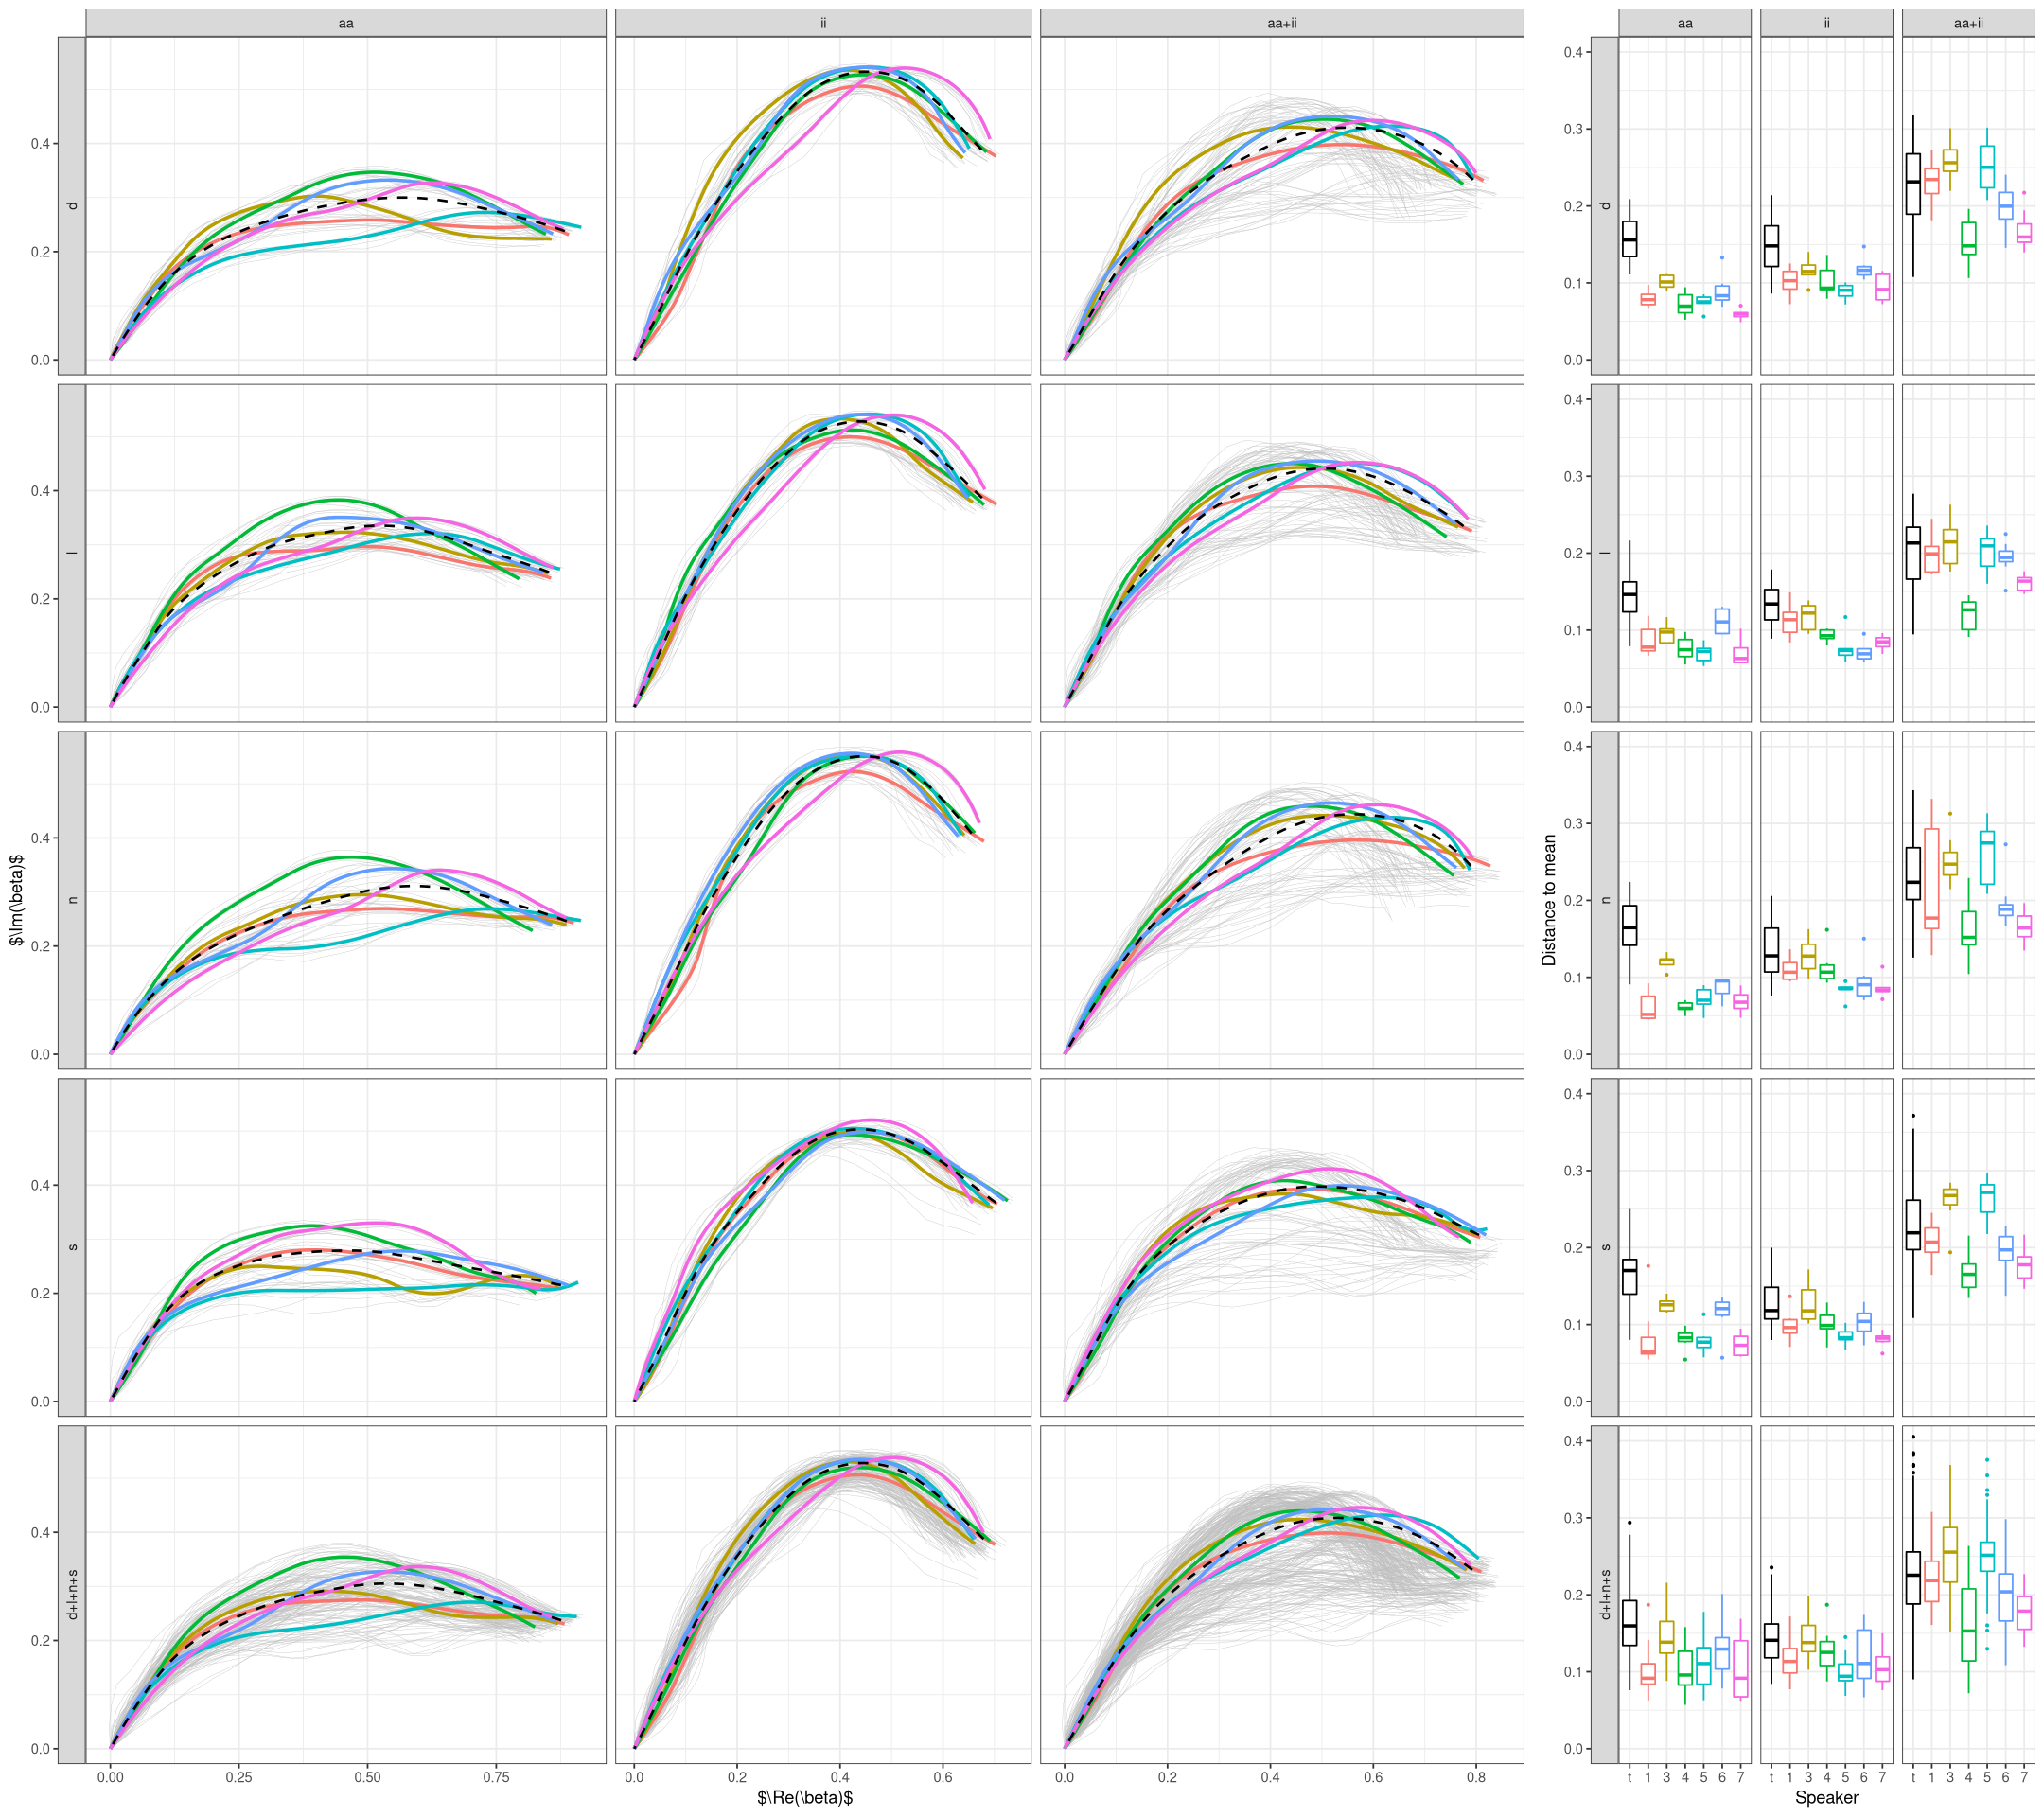

In [45]:
p1 <- ggplot(vpn.pfits, aes(x=X1, y=X2)) + 
    geom_path(aes(group=interaction(VPN, REP)), size=.1, color="grey", show.legend=FALSE) +
    geom_path(data=vpn.mean.evals, aes(group=VPN, color=VPN), size=1, show.legend=FALSE) +
    geom_path(data=mean.evals %>% mutate(VPN="all"), aes(group=VPN), size=0.75, linetype="dashed", color="black", show.legend=FALSE) +
    #coord_fixed(xlim=c(0,0.9),ylim=c(0,0.65)) +
    coord_cartesian() +
    theme_thesis() +
    facet_grid(cols=vars(factor(VCODE, levels = c("aa", "ii", "aa+ii"))), 
               rows=vars(factor(CCODE, levels = c("d", "l", "n", "s", "d+l+n+s"))), 
               switch="y", scale="free_x", space="free_x") +
    xlab("$\\Re(\\beta)$") + ylab("$\\Im(\\beta)$")
        
p2 <- ggplot(vpn.dists) +
    geom_boxplot(aes(y=dist, x=VPN, color=VPN),show.legend=FALSE, outlier.size=0.5) +
    geom_boxplot(data=dists %>% mutate(VPN="all"), aes(y=dist, x=VPN), color="black", show.legend=FALSE, outlier.size=0.5) +
    theme_thesis() +
    coord_cartesian(ylim=c(0,0.4)) +
    facet_grid(cols=vars(factor(VCODE, levels = c("aa", "ii", "aa+ii"))), 
               rows=vars(factor(CCODE, levels = c("d", "l", "n", "s", "d+l+n+s"))), 
               switch="y") +
    scale_x_discrete(labels = c('t','1','3','4','5','6','7')) +
    xlab("Speaker") + ylab("Distance to mean")

options(repr.plot.width=18, repr.plot.height=16)
g <- arrangeGrob(p1, p2, widths=c(3,1))
ggsave("all_means.png", g, width=12, height=11.5, device="png", dpi=300)
grid.draw(g)

fname = "../tex/graphics/44-tounge-means.tex"
tikzDevice::tikz(file = fname, width = 4.5, height = 5.8)
p1
dev.off()
lines <- readLines(con=fname)
lines <- lines[-which(grepl("\\path\\[clip\\]*", lines,perl=F))]
lines <- lines[-which(grepl("\\path\\[use as bounding box*", lines,perl=F))]
writeLines(lines,con=fname)

fname = "../tex/graphics/44-tounge-dists.tex"
tikzDevice::tikz(file = fname, width = 2.5, height = 5.8)
p2
dev.off()
lines <- readLines(con=fname)
lines <- lines[-which(grepl("\\path\\[clip\\]*", lines,perl=F))]
lines <- lines[-which(grepl("\\path\\[use as bounding box*", lines,perl=F))]
writeLines(lines,con=fname)

## Advanced: Difference over Vocal Context using Procrustes Residuals

(probably not geometrically sound...)

#### Function for calculating Procrustes residuals (on SRV level!)

In [14]:
get_procrustes_residuals <- function(mean){
    
    # Calculate average rotation.
    avg.rot <- mean(sapply(mean$data_curves, function(curve){
        attr(curve, "rotation")
    }))
    mat.rot <- matrix(c(cos(- avg.rot), - sin(- avg.rot), sin(- avg.rot), cos(- avg.rot)), nrow = 2, ncol = 2)

    # Get procrustes fits on SRV level.
    pfits <- lapply(mean$data_curves, function(curve){
        pfit <- get_procrustes_fit(curve)
    })
    t_optims <- lapply(pfits, function(pfit){
        pfit$t_optim
    })
    pfits.srv <- lapply(pfits, function(pfit){
        pfit$t_optim <- NULL
        elasdics::get_srv_from_points(pfit)
    })
    
    # Get complex mean coefs.
    coefs.compl <- complex(re=mean$coefs[,1], im=mean$coefs[,2])
    
    # Get residuals data on SRV level.
    residual.data <- elasticproc2d:::get_model_data_complex(t_optims, pfits.srv, mean$knots, mean$type)
    residual.data$q_m_long <- residual.data$q_m_long - elasticproc2d:::make_design(residual.data$m_long, knots, "smooth") %*% coefs.compl
   
    # Split by id.
    residuals <- lapply(seq_along(mean$data_curves), function(i){
        residual <- residual.data[residual.data$id == i,]
        residual$t <- residual$m_long
        residual$X1 <- Re(residual$q_m_long)
        residual$X2 <- Im(residual$q_m_long)
        residual$q <- residual$q_m_long
        residual$id <- NULL
        residual$m_long <- NULL
        residual$q_m_long <- NULL
        residual
    })
    
    # Return.
    residuals
}

### a.) Calculate global mean function (may take some time!)

In [15]:
knots <- seq(0, 1, length = 19)
v.mean <- compute_elastic_proc2d_mean(v.list, knots = knots, type = "smooth", penalty = 2)

In [16]:
center <- FALSE

In [17]:
v.pfits <- build_df_from_group(get_aligned_pfits(v.mean, center=center), v.key)

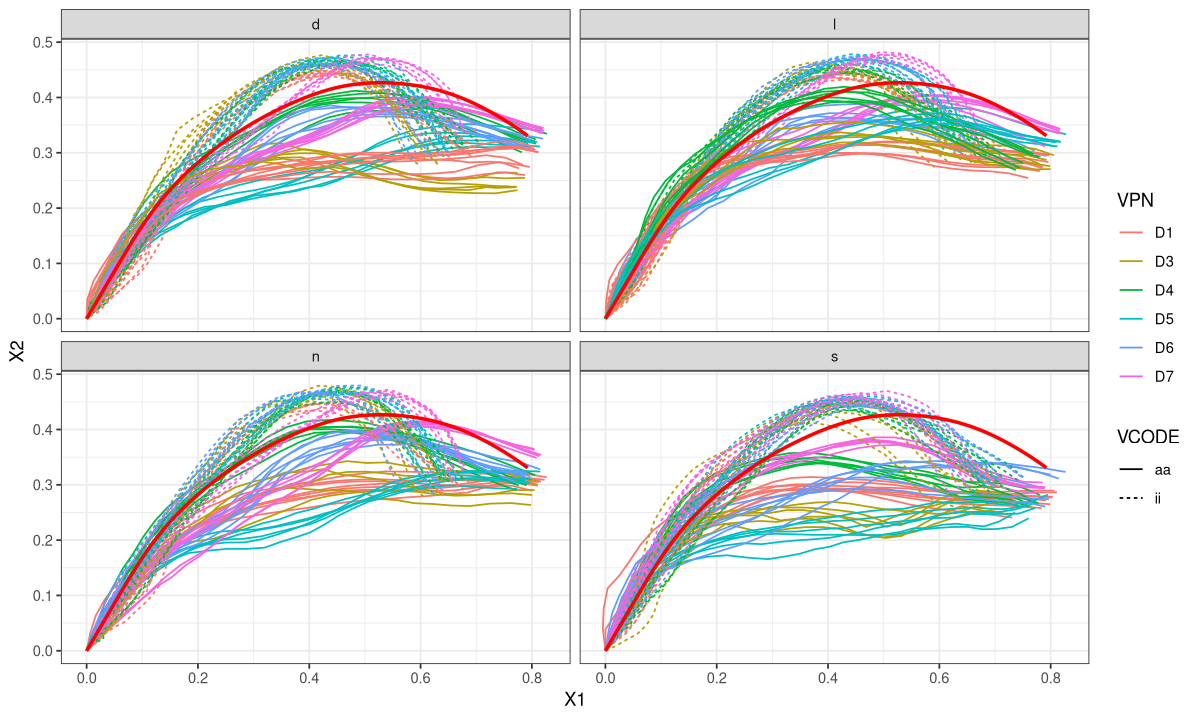

In [18]:
ggplot(v.pfits, aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id, color=VPN, linetype=VCODE)) +
    geom_path(data=get_aligned_mean(v.mean, center=center), aes(x=X1, y=X2), size=1, color="red") +
    #coord_fixed(xlim=c(0,0.9),ylim=c(0,0.6)) +
    theme_thesis() +
    facet_wrap(~ CCODE)

### b.) Calculate Procrustes residuals

In [19]:
resids <- get_procrustes_residuals(v.mean)
v.resids <- build_df_from_group(resids, v.key)

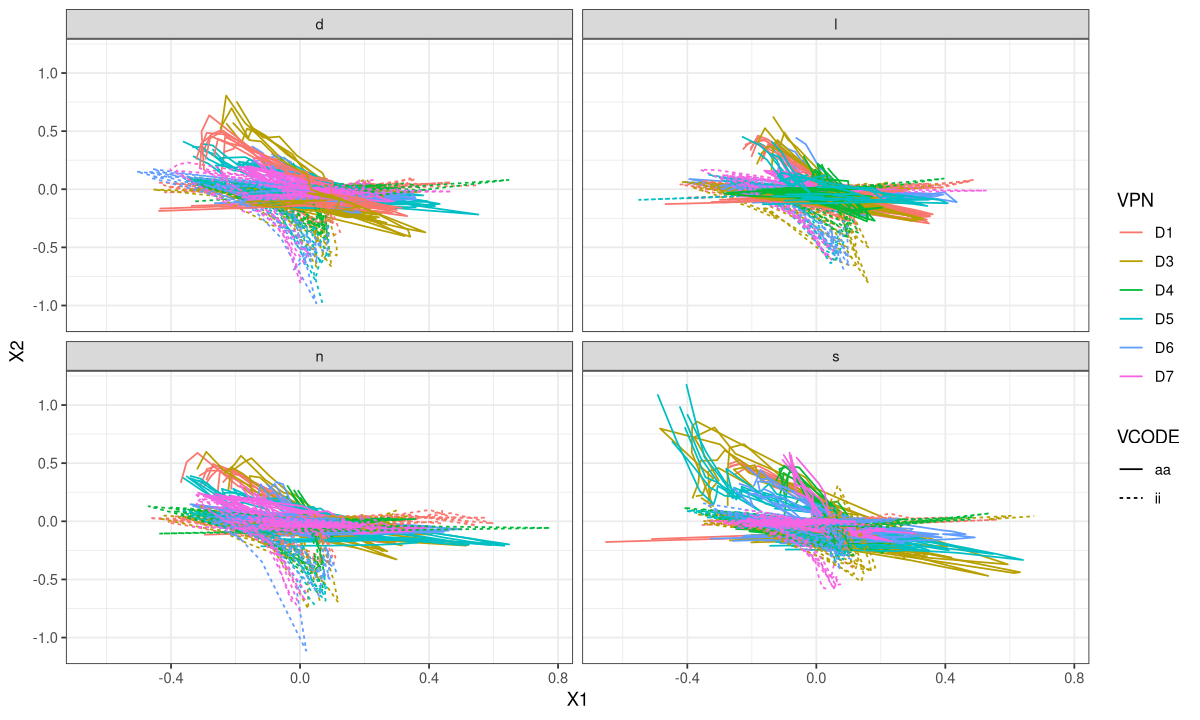

In [20]:
ggplot(v.resids, aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id, color=VPN, linetype=VCODE)) +
    theme_thesis() +
    facet_wrap(~ CCODE)

### c.) Estimate mean residual function for every pair (word, person)

In [21]:
v.resid.mean.keys <- df %>%
    select(CCODE, VCODE, VPN, REP, X1, X2) %>%
    group_by(CCODE, VCODE, VPN) %>%
    group_keys()

In [22]:
v.resid.mean.coefs <- lapply(seq(nrow(v.resid.mean.keys)), function(i){
    # Build dataframe over reps of pair (word, person).
    key <- v.resid.mean.keys[i,]
    model.data <- v.resids %>%
        filter(CCODE == key$CCODE, VCODE == key$VCODE, VPN == key$VPN) %>%
        select(t, X1, X2)
    # Estimate coefs of mean function for (word, person) in global mean basis.
    coefs.X1 <- coef(lm(model.data$X1 ~ -1 + elasticproc2d:::make_design(model.data$t, knots = v.mean$knots, closed = FALSE, type = v.mean$type)))
    coefs.X2 <- coef(lm(model.data$X2 ~ -1 + elasticproc2d:::make_design(model.data$t, knots = v.mean$knots, closed = FALSE, type = v.mean$type)))
    coefs <- data.frame(X1 = coefs.X1, X2 = coefs.X2)
    rownames(coefs) <- NULL
    coefs
})

In [23]:
v.resid.mean.evals <- lapply(v.resid.mean.coefs, function(coefs){
    arg.grid <- seq(0,1,by=0.01)
    evals.X1 <- elasticproc2d:::make_design(arg.grid, knots = v.mean$knots, closed = FALSE, type = v.mean$type) %*% coefs$X1
    evals.X2 <- elasticproc2d:::make_design(arg.grid, knots = v.mean$knots, closed = FALSE, type = v.mean$type) %*% coefs$X2
    data.frame(t=arg.grid, X1 = evals.X1, X2 = evals.X2)
})

In [24]:
v.resid.means <- build_df_from_group(v.resid.mean.evals, v.resid.mean.keys)

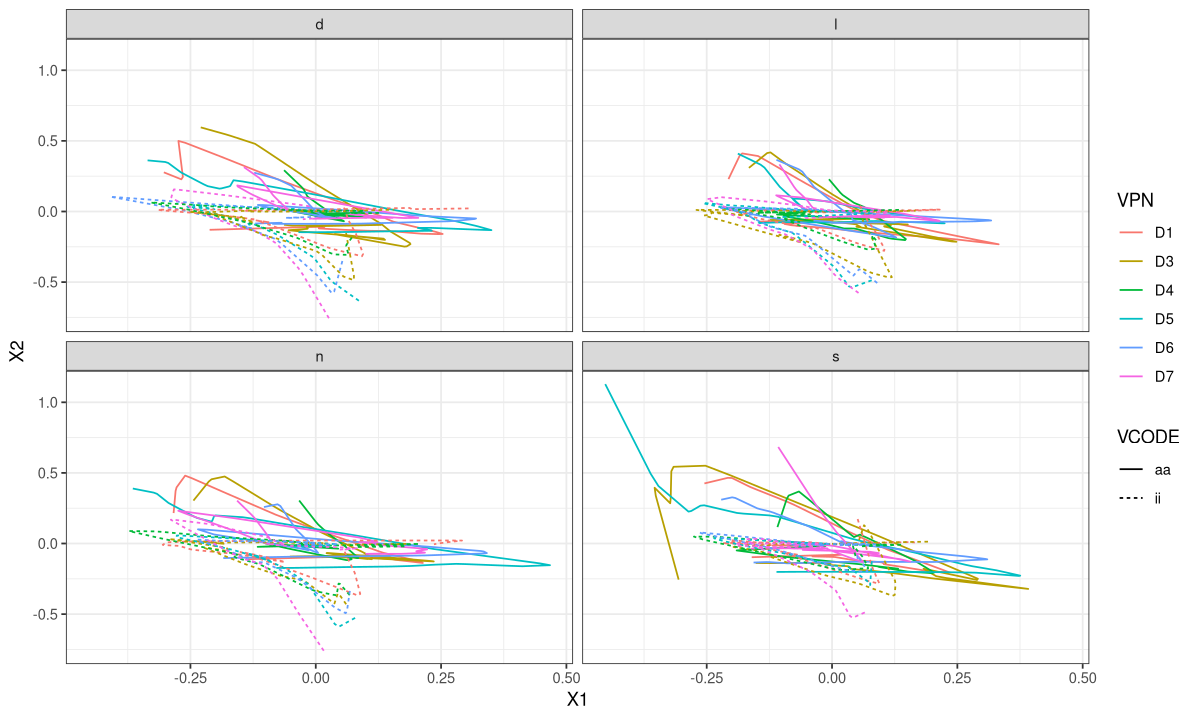

In [25]:
ggplot(v.resid.means, aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id, color=VPN, linetype=VCODE)) +
    theme_thesis() +
    facet_wrap(~ CCODE)

### d.) Calculate  "aa" - "ii" (t) for every (consonant, person)

In [26]:
v.dist.keys <- df %>%
    select(CCODE, VCODE, VPN, REP, X1, X2) %>%
    group_by(CCODE, VPN) %>%
    group_keys()

v.resid.mean.coef.df <- build_df_from_group(v.resid.mean.coefs, v.resid.mean.keys)

In [27]:
v.dist.coefs <- lapply(seq(nrow(v.dist.keys)), function(i){
    # Get coefs of aa and ii for pair (ccode, person)
    key <- v.dist.keys[i,]
    model.data <- v.resid.mean.coef.df %>%
        filter(CCODE == key$CCODE, VPN == key$VPN) %>%
        select(VCODE, X1, X2)
    coefs.aa <- model.data %>% filter(VCODE == "aa") %>% select(X1, X2)
    coefs.ii <- model.data %>% filter(VCODE == "ii") %>% select(X1, X2)
    coefs.X1 <- coefs.aa$X1 - coefs.ii$X1
    coefs.X2 <- coefs.aa$X2 - coefs.ii$X2
    coefs <- data.frame(X1 = coefs.X1, X2 = coefs.X2)
    rownames(coefs) <- NULL
    coefs
})

In [28]:
v.dist.evals <- lapply(v.dist.coefs, function(coefs){
    arg.grid <- seq(0,1,by=0.01)
    evals.X1 <- elasticproc2d:::make_design(arg.grid, knots = v.mean$knots, closed = FALSE, type = v.mean$type) %*% coefs$X1
    evals.X2 <- elasticproc2d:::make_design(arg.grid, knots = v.mean$knots, closed = FALSE, type = v.mean$type) %*% coefs$X2
    data.frame(t=arg.grid, X1 = evals.X1, X2 = evals.X2)
})

In [29]:
v.dists <- build_df_from_group(v.dist.evals, v.dist.keys)

#### dist_x(t), dist_y(t). Achtung: Anfang der Zunge bei $t=1$ !

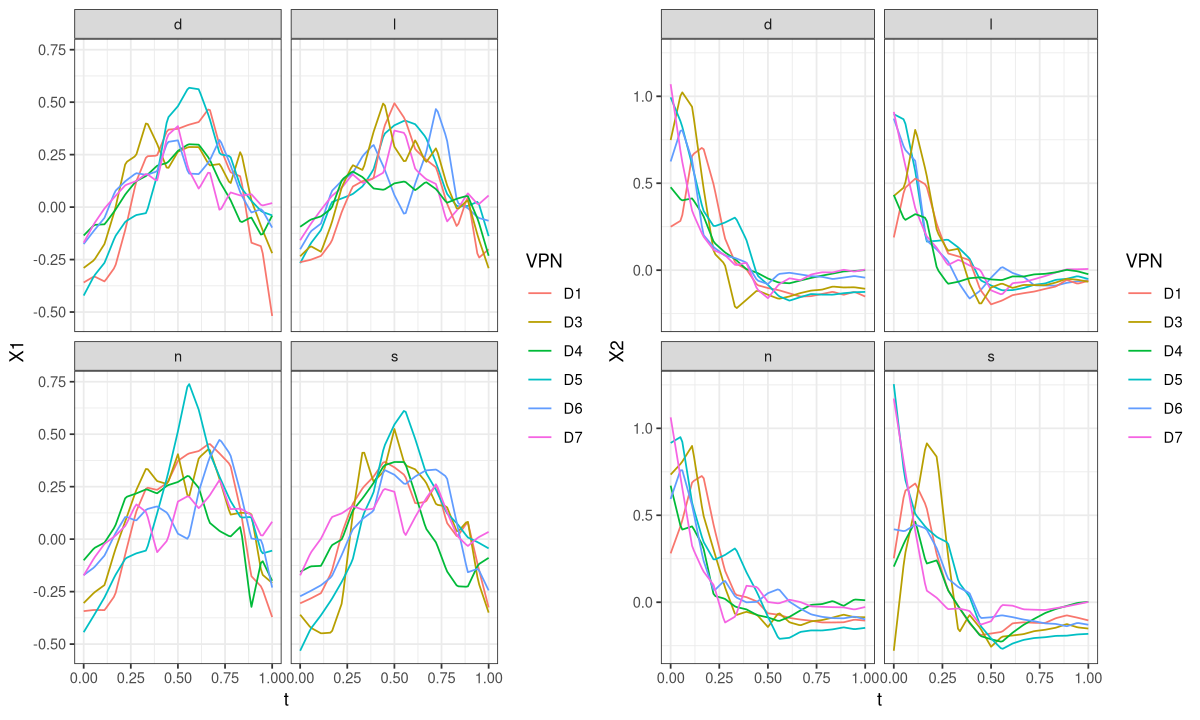

In [30]:
p.X1 <- ggplot(v.dists, aes(x=t, y=X1)) + 
    geom_path(size=0.5, aes(group=id, color=VPN)) +
    theme_thesis() +
    facet_wrap(~ CCODE)
p.X2 <- ggplot(v.dists, aes(x=t, y=X2)) + 
    geom_path(size=0.5, aes(group=id, color=VPN)) +
    theme_thesis() +
    facet_wrap(~ CCODE)

grid.arrange(p.X1, p.X2, nrow=1)

#### Plot absolute distance |"aa" - "ii"|(t) for every pair (person, consonant)

In [31]:
v.dists$dist <- sqrt(v.dists$X1^2 + v.dists$X2^2)

png 
  2

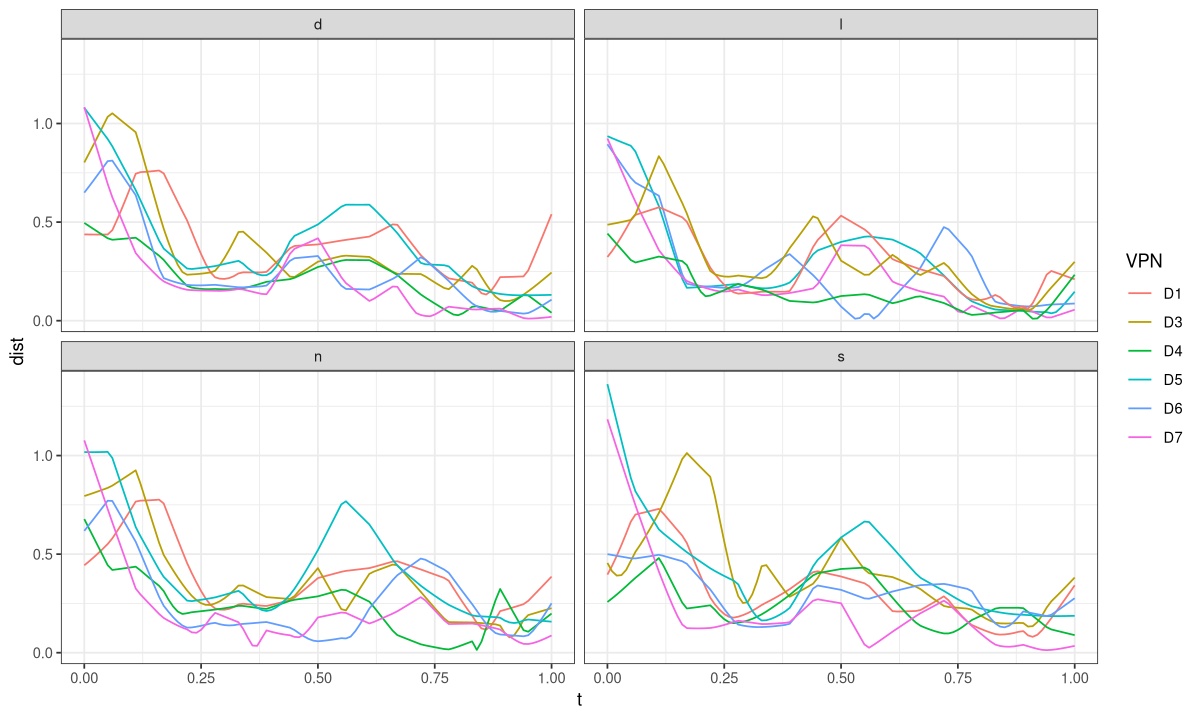

In [32]:
p.diffs.vpn <- ggplot(v.dists, aes(x=t, y=dist)) +
    geom_path(size=0.5, aes(group=id, color=VPN)) +
    theme_thesis() +
    facet_wrap(~ CCODE)
    
fname = "../tex/graphics/4-diffs-vpn.tex"
tikzDevice::tikz(file = fname, width = 6, height = 3)
p.diffs.vpn
dev.off()
p.diffs.vpn
lines <- readLines(con=fname)
lines <- lines[-which(grepl("\\path\\[clip\\]*", lines,perl=F))]
lines <- lines[-which(grepl("\\path\\[use as bounding box*", lines,perl=F))]
writeLines(lines,con=fname)

### e.) Calculate mean distance over VPN

In [33]:
v.cons.keys <- df %>%
    select(CCODE, VCODE, VPN, REP, X1, X2) %>%
    group_by(CCODE) %>%
    group_keys()

v.dist.coef.df <- build_df_from_group(v.dist.coefs, v.dist.keys)

In [34]:
v.cons.coefs <- lapply(seq(nrow(v.cons.keys)), function(i){
    # Get coefs of aa and ii for pair (ccode, person)
    key <- v.cons.keys[i,]
    model.data <- v.dist.coef.df %>%
        filter(CCODE == key$CCODE) %>%
        select(VPN, X1, X2)
    X1.data <- model.data %>% select(VPN, X1) %>% group_split(VPN, .keep=FALSE)
    X2.data <- model.data %>% select(VPN, X2) %>% group_split(VPN, .keep=FALSE)
    coefs.X1 <- rowMeans(do.call(cbind, X1.data))
    coefs.X2 <- rowMeans(do.call(cbind, X2.data))
    coefs <- data.frame(X1 = coefs.X1, X2 = coefs.X2)
    rownames(coefs) <- NULL
    coefs
})

In [35]:
v.cons.evals <- lapply(v.cons.coefs, function(coefs){
    arg.grid <- seq(0,1,by=0.01)
    evals.X1 <- elasticproc2d:::make_design(arg.grid, knots = v.mean$knots, closed = FALSE, type = v.mean$type) %*% coefs$X1
    evals.X2 <- elasticproc2d:::make_design(arg.grid, knots = v.mean$knots, closed = FALSE, type = v.mean$type) %*% coefs$X2
    data.frame(t=arg.grid, X1 = evals.X1, X2 = evals.X2)
})

In [36]:
v.cons <- build_df_from_group(v.cons.evals, v.cons.keys)

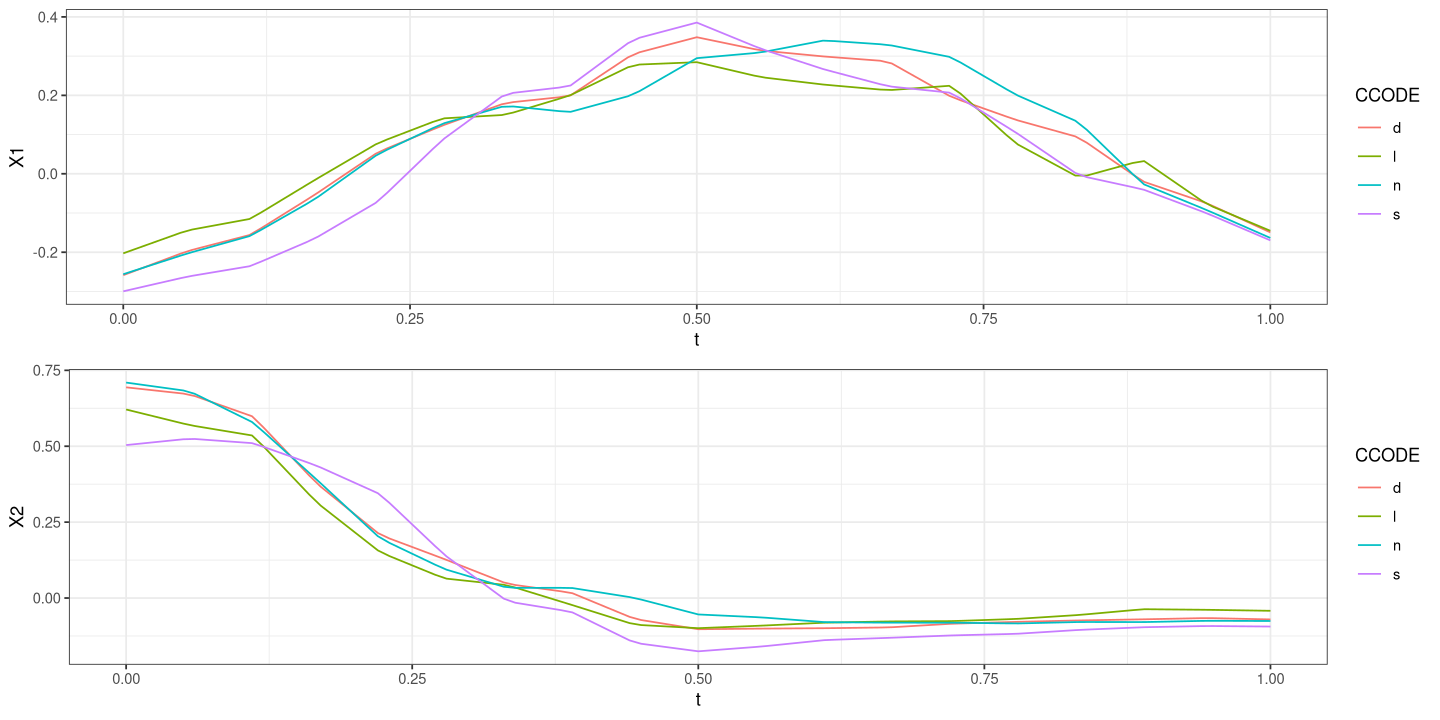

In [49]:
p.X1 <- ggplot(v.cons, aes(x=t, y=X1)) + 
    geom_path(size=0.5, aes(group=id, color=CCODE)) +
    theme_thesis()
p.X2 <- ggplot(v.cons, aes(x=t, y=X2)) + 
    geom_path(size=0.5, aes(group=id, color=CCODE)) +
    theme_thesis()

grid.arrange(p.X1, p.X2, ncol=1)

In [38]:
v.cons$dist <- sqrt(v.cons$X1^2 + v.cons$X2^2)

png 
  2

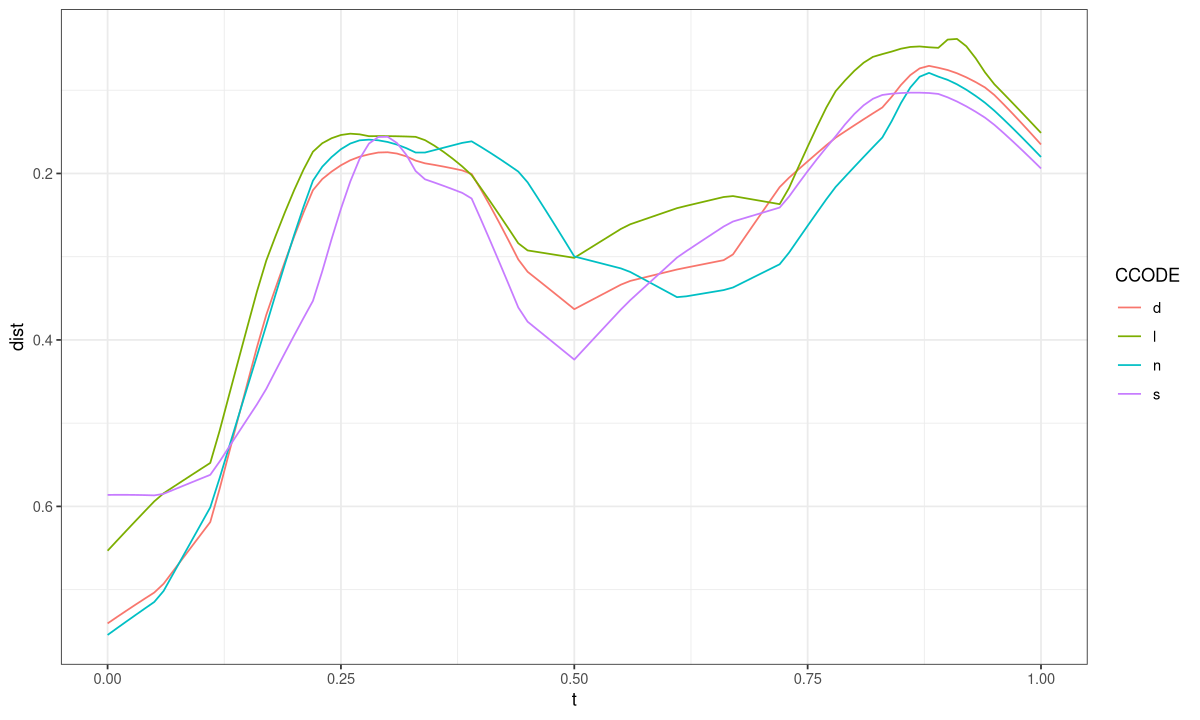

In [39]:
p.diffs <- ggplot(v.cons, aes(x=t, y=dist)) +
    geom_path(size=0.5, aes(group=id, color=CCODE)) +
    theme_thesis() +
    scale_y_reverse()
    
fname = "../tex/graphics/4-diffs.tex"
tikzDevice::tikz(file = fname, width = 6, height = 3)
p.diffs
dev.off()
p.diffs
lines <- readLines(con=fname)
lines <- lines[-which(grepl("\\path\\[clip\\]*", lines,perl=F))]
lines <- lines[-which(grepl("\\path\\[use as bounding box*", lines,perl=F))]
writeLines(lines,con=fname)